Importing Tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
MODEL = "VGG19" # VGG16, VGG19, InceptionV3, Xception, ResNet50

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

print("Successfully imported libraries.")

Successfully imported libraries.


Getting Data

In [3]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Get this dataset
data_dir = pathlib.Path("./Dataset")

image_count = len(list(data_dir.glob("*/*.jp*g")))
print("Images available to use: " + str(image_count))

GPUs Available:  []
Images available to use: 14566


In [5]:
# Put into an image dataset.

batch_size = 64
img_height = 224
img_width = 224
channels = 3
preprocess = tf.keras.applications.imagenet_utils.preprocess_input

if MODEL in ("InceptionV3", "Xception"):
    # Image size should be (299, 299)
    img_height = 299
    img_width = 299

if MODEL == "InceptionV3":
    # Use different preprocessing function
    preprocess = tf.keras.applications.inception_v3.preprocess_input
if MODEL == "Xception":
    # Use different preprocessing function
    preprocess = tf.keras.applications.xception.preprocess_input


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode=("grayscale" if channels == 1 else "rgb"),
    seed=1314,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=314,
    color_mode=("grayscale" if channels == 1 else "rgb"),
    image_size=(img_height,img_width),
    batch_size=batch_size
)

# Apply preprocessing:
class_names = train_ds.class_names

train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess(x), y))

print(F"Using classes: {', '.join(class_names)}")
print(F"Image shape: ({img_width}, {img_height}, {channels})")

Found 14571 files belonging to 2 classes.
Using 11657 files for training.
Found 14571 files belonging to 2 classes.
Using 2914 files for validation.
Using classes: Guns, No Guns
Image shape: (224, 224, 3)


Visualizing Dataset

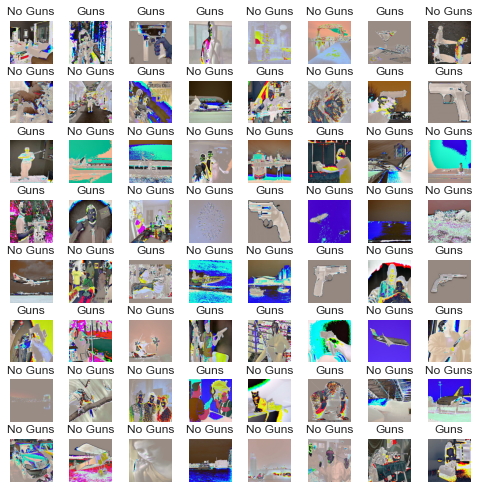

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(8, 8))

for images, labels in train_ds.take(1):
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]], fontsize=12)
        plt.axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.savefig("sample_img.jpg")
plt.show()

Performance Tuning

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the Model!

In [8]:
num_classes = len(class_names)

map_model = {
    "InceptionV3": tf.keras.applications.InceptionV3,
    "VGG16": tf.keras.applications.VGG16,
    "VGG19": tf.keras.applications.VGG19,
    "Xception": tf.keras.applications.Xception
}

model = map_model[MODEL](include_top=True, weights=None, classes=num_classes, input_shape=(img_width, img_height, 3))

tf.keras.utils.plot_model(model, to_file=F"{MODEL}-Structure-Concat.png")
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# Compile model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", "mse"])

# Save model here every 200 batches
checkpoint_path = F"{MODEL}/{MODEL}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=200)


In [10]:
# Start training!
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback]
)

Epoch 1/15
180/183 [============================>.] - ETA: 46s - loss: 1000238559002624.0000 - accuracy: 0.5362 - mse: 0.4196 

Analyze Results

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('AlexNet: Training and Validation Accuracy')
plt.savefig("Pictures/alexnet_accuracy.png")
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('AlexNet: Training and Validation Loss')
plt.savefig("Pictures/alexnet_loss.png")
plt.show()

NameError: name 'history' is not defined

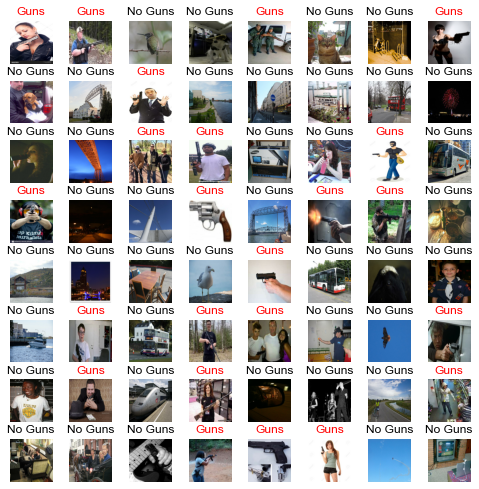

Set results:
------------------------------------------------
[[ 0 23]
 [ 0 41]]
kappa:        0.0
accuracy:     0.640625
recall:       [0. 1.]
precision:    [0.       0.640625]
f_1:          [0.         0.78095238]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


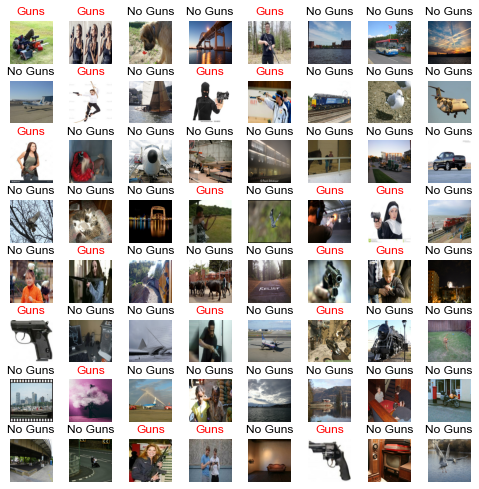

Set results:
------------------------------------------------
[[ 0 20]
 [ 0 44]]
kappa:        0.0
accuracy:     0.6875
recall:       [0. 1.]
precision:    [0.     0.6875]
f_1:          [0.         0.81481481]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


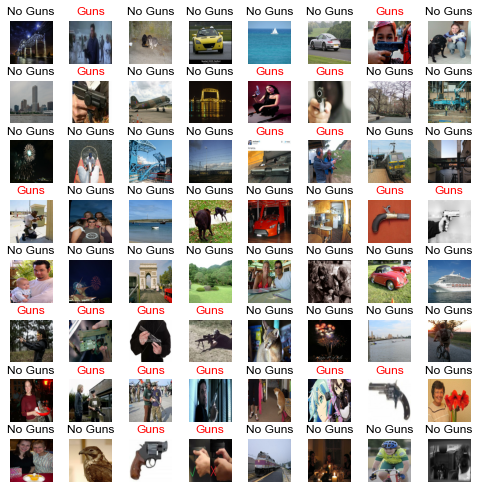

Set results:
------------------------------------------------
[[ 0 21]
 [ 0 43]]
kappa:        0.0
accuracy:     0.671875
recall:       [0. 1.]
precision:    [0.       0.671875]
f_1:          [0.         0.80373832]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


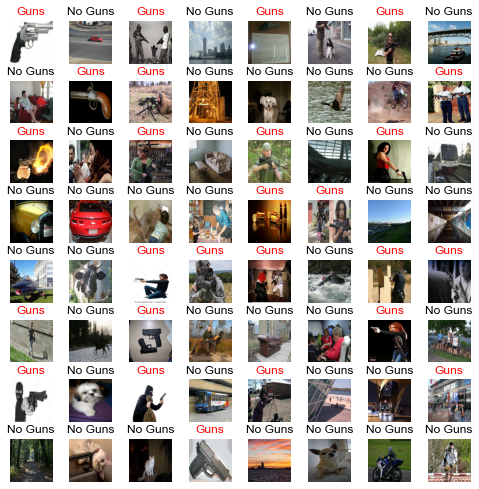

Set results:
------------------------------------------------
[[ 0 26]
 [ 0 38]]
kappa:        0.0
accuracy:     0.59375
recall:       [0. 1.]
precision:    [0.      0.59375]
f_1:          [0.         0.74509804]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


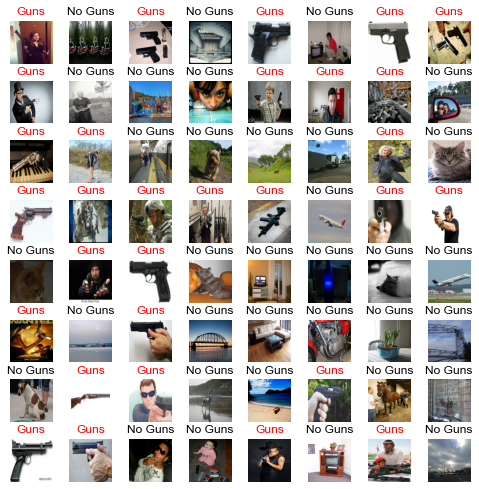

Set results:
------------------------------------------------
[[ 0 30]
 [ 0 34]]
kappa:        0.0
accuracy:     0.53125
recall:       [0. 1.]
precision:    [0.      0.53125]
f_1:          [0.         0.69387755]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


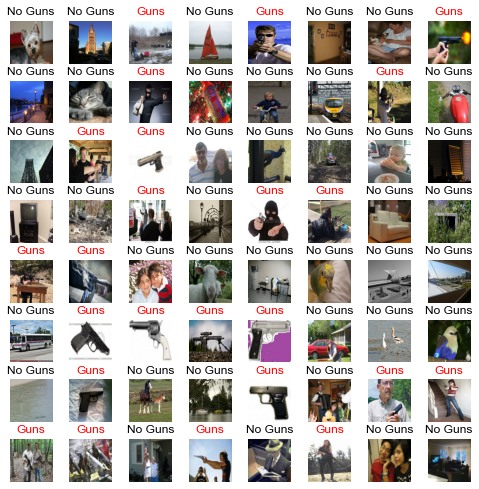

Set results:
------------------------------------------------
[[ 0 24]
 [ 0 40]]
kappa:        0.0
accuracy:     0.625
recall:       [0. 1.]
precision:    [0.    0.625]
f_1:          [0.         0.76923077]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


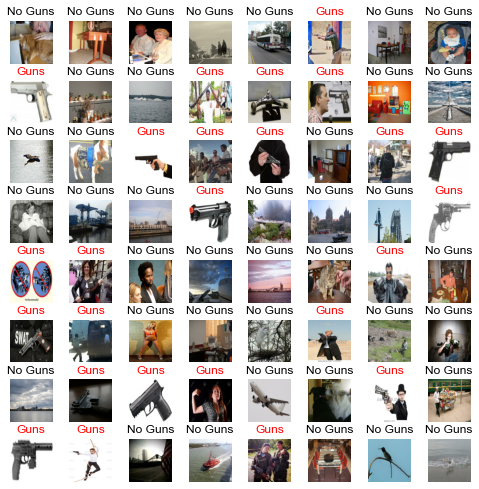

Set results:
------------------------------------------------
[[ 0 25]
 [ 0 39]]
kappa:        0.0
accuracy:     0.609375
recall:       [0. 1.]
precision:    [0.       0.609375]
f_1:          [0.         0.75728155]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


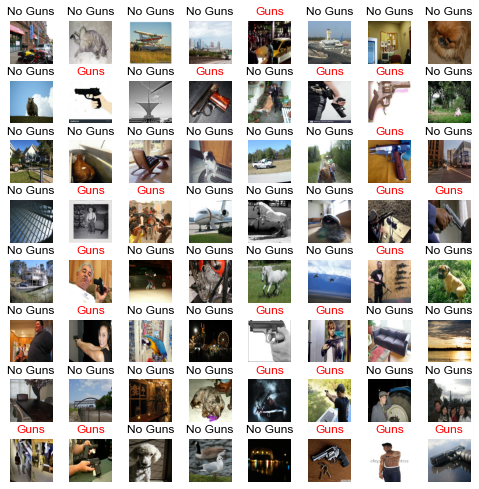

Set results:
------------------------------------------------
[[ 0 22]
 [ 0 42]]
kappa:        0.0
accuracy:     0.65625
recall:       [0. 1.]
precision:    [0.      0.65625]
f_1:          [0.         0.79245283]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


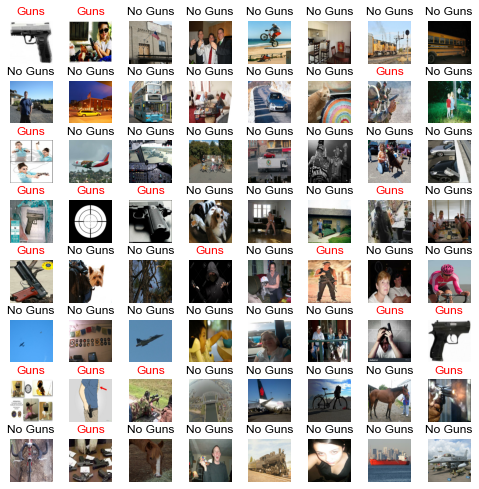

Set results:
------------------------------------------------
[[ 0 18]
 [ 0 46]]
kappa:        0.0
accuracy:     0.71875
recall:       [0. 1.]
precision:    [0.      0.71875]
f_1:          [0.         0.83636364]


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


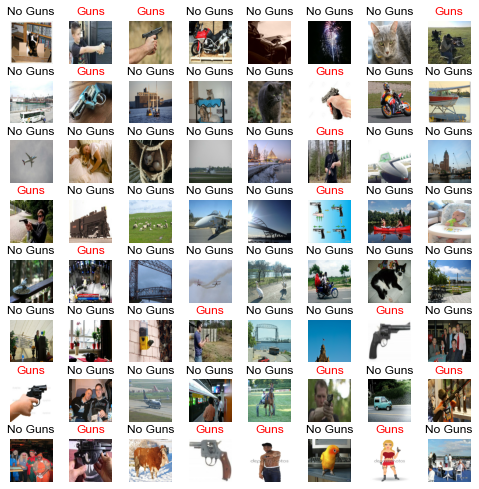

Set results:
------------------------------------------------
[[ 0 18]
 [ 0 46]]
kappa:        0.0
accuracy:     0.71875
recall:       [0. 1.]
precision:    [0.      0.71875]
f_1:          [0.         0.83636364]
Analyzing batch 0
Analyzing batch 1


C:\Users\sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Analyzing batch 2
Analyzing batch 3
Analyzing batch 4
Analyzing batch 5
Analyzing batch 6
Analyzing batch 7
Analyzing batch 8
Analyzing batch 9
Analyzing batch 10
Analyzing batch 11
Analyzing batch 12
Analyzing batch 13
Analyzing batch 14
Analyzing batch 15
Analyzing batch 16
Analyzing batch 17
Analyzing batch 18
Analyzing batch 19
Analyzing batch 20
Analyzing batch 21
Analyzing batch 22
Analyzing batch 23
Analyzing batch 24
Analyzing batch 25
Analyzing batch 26
Analyzing batch 27
Analyzing batch 28
Analyzing batch 29
Analyzing batch 30
Analyzing batch 31
Analyzing batch 32
Analyzing batch 33
Analyzing batch 34
Analyzing batch 35
Analyzing batch 36
Analyzing batch 37
Analyzing batch 38
Analyzing batch 39
Analyzing batch 40
Analyzing batch 41
Analyzing batch 42
Analyzing batch 43
Analyzing batch 44
Analyzing batch 45


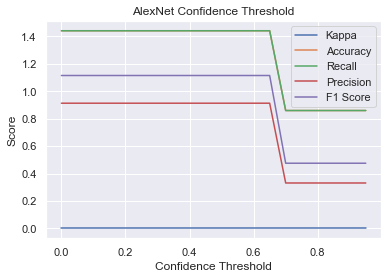

In [25]:
import sklearn.metrics as metrics
import seaborn as sns
sns.set_theme()

def print_results(y_test, y_pred):
    # Show the test data's result
    print("Set results:")
    print("------------------------------------------------")
    # y_test = y_test.argmax(axis=1)
    # y_pred = y_pred.argmax(axis=1)
    print(metrics.confusion_matrix(y_test, y_pred))
    print('kappa:       ', metrics.cohen_kappa_score(y_test, y_pred))
    print('accuracy:    ', metrics.accuracy_score(y_test, y_pred))
    print('recall:      ', metrics.recall_score(y_test, y_pred, average=None))
    print('precision:   ', metrics.precision_score(y_test, y_pred, average=None))
    print('f_1:         ', metrics.f1_score(y_test, y_pred, average=None))

for images, labels in val_ds.take(10):
    fig = plt.figure(figsize=(8, 8))
    label_pred = model.predict(images)
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]], fontsize=12, color = "black" if labels[i] == np.argmax(label_pred[i]) else "red")
        plt.axis("off")
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    print_results(labels, np.argmax(label_pred, axis=1))

# For a batch, find the best confidence threshold.

x_points = np.arange(0, 1, 0.05)
y_point1 = np.zeros(len(x_points))
y_point2 = np.zeros(len(x_points))
y_point3 = np.zeros(len(x_points))
y_point4 = np.zeros(len(x_points))
y_point5 = np.zeros(len(x_points))
batch = 0
for images, labels in val_ds.take(300):
    print(F"Analyzing batch {batch}")
    label_pred = model.predict(images)
    x_point = 0
    for thresh in x_points:
        y_point1[x_point] += (metrics.cohen_kappa_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point2[x_point] += (metrics.accuracy_score(labels, [i[1] > thresh for i in label_pred])) / len(x_points)
        y_point3[x_point] += (metrics.recall_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        y_point4[x_point] += (metrics.precision_score(labels, [i[1] > thresh for i in label_pred], average='weighted', zero_division=0)) / len(x_points)
        y_point5[x_point] += (metrics.f1_score(labels, [i[1] > thresh for i in label_pred], average='weighted')) / len(x_points)
        x_point += 1
    batch += 1

fig, ax = plt.subplots()
plot_1, = plt.plot(x_points, y_point1, label = "Kappa")
plot_2, = plt.plot(x_points, y_point2, label = "Accuracy")
plot_3, = plt.plot(x_points, y_point3, label = "Recall")
plot_4, = plt.plot(x_points, y_point4, label = "Precision")
plot_5, = plt.plot(x_points, y_point5, label = "F1 Score")
ax.legend(handles=[plot_1, plot_2, plot_3, plot_4, plot_5])
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title("AlexNet Confidence Threshold")

plt.savefig("Pictures/alexnet_confthresh.png")

plt.show()